# Exercise 01 Recap ML & Ensemble Learning I

<span style="color:red">**Due date for submission: January 22, 2025 at 23:59**</span>

## Pedagogy

This notebook contains both theoretical explanations and executable cells to execute your code.

When you see the <span style="color:red">**[TBC]**</span> (To Be Completed) sign, it means that you need to perform an action else besides executing the cells of code that already exist. These actions can be:
- Complete the code with proper comments
- Respond to a question
- Write an analysis
- etc.

### Import libraries

In [32]:
# import all libraries used in this notebook here
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

In [2]:
# suppress all warnings
warnings.filterwarnings("ignore")

## Part 1. Recap of Classic ML

In this part, we will implement the best practice of supervised learning to build a classification model using the decision tree algorithm.

We will execute the following steps:
- Load the dataset
- Split the dataset into training and test set
- Hyper-parameter tuning through cross-validation using the training dataset
- Evaluation the best model with the best hyper-parameters using the test dataset
- Inference with unseen data

### 1.1. Load dataset

We will use a toy dataset, the Iris plants dataset, provided by `scikit-learn` here.

There are four feature variables and one target variables in this dataset, which are:
- Feature
    - Sepal length in cm
    - Sepal width in cm
    - Petal length in cm
    - Petal width in cm
- Target
    - Class of iris
        - Iris-Setosa
        - Iris-Versicolour
        - Iris-Virginica
        
There are 150 labeled examples in the dataset.

Use `sklearn.datasets.load_iris()` to get this dataset.

In [3]:
# load dataset
feature_df, target_df = datasets.load_iris(
    return_X_y = True, # If True, returns (data.data, data.target) instead of a Bunch object.
    as_frame = True # If True, the data is a pandas DataFrame including columns with appropriate dtypes (numeric).
)

In [4]:
# display the first five rows of the features
feature_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [5]:
# display the unique values of the target variable
target_df.unique()

array([0, 1, 2])

### 1.2. Train test split

We will split the whole dataset into two parts: the training and test dataset.
- 70% for training
- 30% for test

Use `sklearn.model_selection.train_test_split()` to do this.

In [6]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(
    feature_df.values, # call `.values` to convert the feature from pd.DataFrame to np.array
    target_df.values, # call `.values` to convert the target from pd.Series to np.array
    train_size = 0.7, # 70% for training, 30% for test
    shuffle = True, # shuffle the samples before splitting
    random_state = 0 # controls the shuffling, set to zero for reproduciblillity
)

### 1.3. Hyper-parameter tuning through cross-validation

We will perform hyper-parameter tuning through cross-validation using `sklearn.model_selection.GridSearchCV()` on the training dataset.
- First, define the potential values of hyper-parameters for search
- Call `sklearn.model_selection.GridSearchCv()` to perform an exhausive search
    - Use weighted average of F1-Score as the evaluatoin metric
    - Set the number of folds to 5 for the cross-validation

In [7]:
# define the hyper-parameters to search
param_dict = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [1, 2]
}

In [8]:
# hyper-parameter tuning through cross-validation
grid_clf = GridSearchCV(
    estimator = DecisionTreeClassifier(),
    param_grid = param_dict,
    scoring = 'f1_weighted',
    refit = True,
    cv = 5,
    verbose = 1,
    n_jobs = -1
)
grid_clf.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [1, 2]},
             scoring='f1_weighted', verbose=1)

In [9]:
# obtain the best hyper-parameters and the best score
print('Best hyper-parameters:', grid_clf.best_params_)
print('Best score:', grid_clf.best_score_)

Best hyper-parameters: {'criterion': 'gini', 'max_depth': 2}
Best score: 0.9331805449452508


### 1.4. Evaluation using the test dataset

After finding the best combination of hyper-parameter values, we can use the test dataset to evaluate the performance of the best model.

If the parameter `refit` was set to `True`, the `GridSearchCV()` has already refitted the model using the best hyper-parameters on the whole training dataset. There is no need to manually refit the model.

In [10]:
# predict categories for test dataset
y_pred = grid_clf.predict(X_test)

In [11]:
# obtain classification metrics using `classification_report`
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       0.85      0.94      0.89        18
           2       0.89      0.73      0.80        11

    accuracy                           0.91        45
   macro avg       0.91      0.89      0.90        45
weighted avg       0.91      0.91      0.91        45



### 1.5. Inference with unseen data

After evaluation, if we are satisfied with the performance of the model, we can then use the learned model to make predictions on unseen data, so called inference.
- Predict the category directly
- Predict the probability of belonging to a specific category

In [12]:
# inference with unseen data
X_unseen = np.array([5.2, 3.1, 1.3, 0.2]) # an unseen example to be classifies
print("The predicted category of the unseen data:", grid_clf.predict(X_unseen.reshape(-1, 4)))
print("The predicted probabilities:", grid_clf.predict_proba(X_unseen.reshape(-1, 4)))

The predicted category of the unseen data: [0]
The predicted probabilities: [[1. 0. 0.]]


## Part 2. The bagging method - Random forests

In this part, we will use the random forests algorith, a bagging method for ensemble learning, to build a classifier with the same dataset.

Random forests is a meta model that fits a number of decision tree classifiers on various sub-samples of the dataset.

### 2.1. Train the random forest using the training dataset

To test whether random forest can improve prediction accuracy compared to a single decision tree model, we set the hyperparameters of each decision tree in the random forest to be the same as the decision tree model after hyperparameter optimization in the Part 1.

The only difference is that, random forest will fit 10 decision trees using 10 different subsets of the training dataset

In [13]:
# create the random forest classifier
clf = RandomForestClassifier(
    n_estimators = 10, # set the number of decision trees to 10
    criterion = grid_clf.best_params_['criterion'],
    max_depth = grid_clf.best_params_['max_depth'],
    n_jobs = -1, # -1 means using all available processors for parallelized computation
    random_state = 0 # set random state to 0 for reproduciblity
)

In [14]:
# fit the model to the training dataset
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=2, n_estimators=10, n_jobs=-1, random_state=0)

### 2.2. Evaluate the random forest using the test dataset

After training, we can using the test dataset to evaluate the performance of the random forest and compare it with the performance of the single decision tree classifier.

In [15]:
# predict categories for test dataset
y_pred = clf.predict(X_test)

In [16]:
# obtain classification metrics using `classification_report`
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       0.94      0.94      0.94        18
           2       0.91      0.91      0.91        11

    accuracy                           0.96        45
   macro avg       0.95      0.95      0.95        45
weighted avg       0.96      0.96      0.96        45



Normally, the performance of random forest should be better than, at least not worse than, the single decision tree classifier.

### 2.3. Obtain feature importances

Ranomd forests provide the importances of different features for the model to make the correct predictions.

We can call the attribute `feature_importances_` to get this information.

In [17]:
# obtain feature importances
clf.feature_importances_

array([0.17792174, 0.01004535, 0.39079193, 0.42124097])

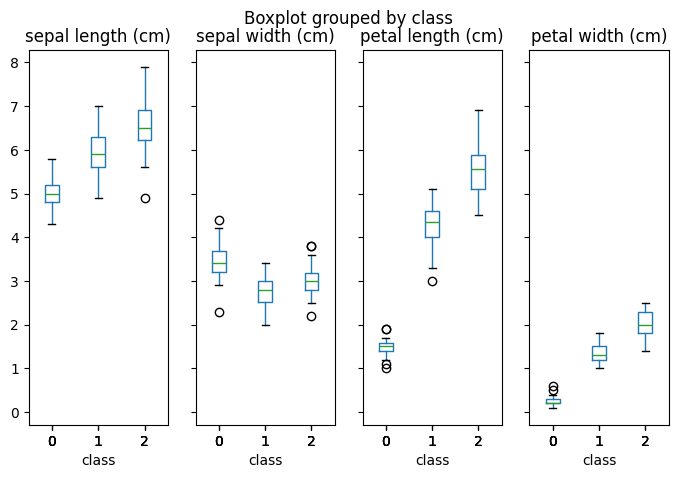

In [18]:
# display the boxplots of the 4 features for the 3 different classes
# merge the feature and target into one DataFrame
df = feature_df
df['class'] = target_df
# create the figure
df.boxplot(
    column = ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)'],
    by = 'class',
    grid = False,
    figsize = (8, 5),
    layout = (1, 4)
)
plt.show()

We can see that for different iris classes:
- Petal length and width are distributed in different intervals, so the importances of these two features are higher.
- The distribution intervals of sepal length overlap slightly, so the importance is low.
- The distribution intervals of sepal width overlap strongly, so the importance is close to zero.

### 2.4. Inference with unseen data

In [19]:
# predict the category and probabilities for the unseen data
print("The predicted category of the unseen data:", clf.predict(X_unseen.reshape(-1, 4)))
print("The predicted probabilities:", clf.predict_proba(X_unseen.reshape(-1, 4)))

The predicted category of the unseen data: [0]
The predicted probabilities: [[1. 0. 0.]]


## Part 3. Hands-on exercise

In this exercise, you are required to build a regression model using the random forests algorithm.

The problem to be solved is predicting the price of flights.

Please download the flight price dataset from Learn.

<span style="color:red">**[TBC]**</span> Please complete the following tasks:

- Load and explore the dataset
- Preprocess the dataset
- Build and evaluate a regression model using random forests with default hyper-parameters
- Hyper-parameter tuning through cross-validation for random forests

### Task 1. Load and explore the dataset

Dataset contains information about flight booking options from the website Easemytrip for flight travel between India's top 6 metro cities.

There are 300,261 datapoints and 11 features in the cleaned dataset.

More details can be found in this [link](https://www.kaggle.com/datasets/shubhambathwal/flight-price-prediction?resource=download#).

<span style="color:red">**[TBC]**</span> Please complete the following tasks:

- Load the dataset
- Obtain the general information of the dataset
- Obtain the number of unique values of each feature in the dataset

In [24]:
# [TBC] complete your code here with proper comments
df = pd.read_csv('flight_price_dataset.csv')

In [25]:
# [TBC] complete your code here with proper comments
# obtain the general information of the dataset
# hint: pandas.DataFrame.info()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300153 entries, 0 to 300152
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        300153 non-null  int64  
 1   airline           300153 non-null  object 
 2   flight            300153 non-null  object 
 3   source_city       300153 non-null  object 
 4   departure_time    300153 non-null  object 
 5   stops             300153 non-null  object 
 6   arrival_time      300153 non-null  object 
 7   destination_city  300153 non-null  object 
 8   class             300153 non-null  object 
 9   duration          300153 non-null  float64
 10  days_left         300153 non-null  int64  
 11  price             300153 non-null  int64  
dtypes: float64(1), int64(3), object(8)
memory usage: 27.5+ MB


In [26]:
# [TBC] complete your code here with proper comments
# obtain the number of unique values of each feature in the dataset
# hint: pandas.DataFrame.nunique()
df.nunique()

Unnamed: 0          300153
airline                  6
flight                1561
source_city              6
departure_time           6
stops                    3
arrival_time             6
destination_city         6
class                    2
duration               476
days_left               49
price                12157
dtype: int64

### Task 2. Preprocess the dataset

You may find some features in the dataset is categorical. Before training, you need to convert these categorical features into numerical variables.

<span style="color:red">**[TBC]**</span> Please complete the following tasks:

- Encode categorical features
- Train test split

In [61]:
# [TBC] complete your code here with proper comments
# Encode categorical features
# hint: sklearn.preprocessing.LabelEncoder()
categorical_columns = ['airline', 'flight', 'source_city', 'departure_time', 'stops', 'arrival_time', 'destination_city', 'class']
label_encoder = LabelEncoder()
for column in categorical_columns:
    df[column] = label_encoder.fit_transform(df[column])

print("\nUnique values after encoding:")
for column in categorical_columns:
    print(f"{column}: {df[column].unique()}")


Unique values after encoding:
airline: [4 0 5 2 3 1]
flight: [1408 1387 1213 ...  558  587  718]
source_city: [2 5 0 4 3 1]
departure_time: [2 1 4 0 5 3]
stops: [2 0 1]
arrival_time: [5 4 1 0 2 3]
destination_city: [5 0 4 3 1 2]
class: [1 0]


In [62]:
# [TBC] complete your code here with proper comments
# Train test split
# hint: sklearn.model_selection.train_test_split()
# hint: first divide the encoded dataset into features and target, then perform train test split

feature_df = df.drop(columns = ['price','Unnamed: 0'])
target_df = df['price']
X_train, X_test, y_train, y_test = train_test_split(
    feature_df.values, # call `.values` to convert the feature from pd.DataFrame to np.array
    target_df.values, # call `.values` to convert the target from pd.Series to np.array
    train_size = 0.7, # 70% for training, 30% for test
    shuffle = True, # shuffle the samples before splitting
    random_state = 0 # controls the shuffling, set to zero for reproduciblility
)

### Task 3. Build and evaluate a regression model using random forests with default hyper-parameters

You need to train a regression model using random forests algorithms with default hyper-parameters and evaluate its performance.

<span style="color:red">**[TBC]**</span> Please complete the following tasks:

- Train the regression model
- Evaluate the performance on test dataset

Warning: The difficulty with this task lies in the size of the data set. If your computer doesn't have enough memory to complete the task, you need to find workarounds.

- You may reduce the size of training set, but be careful of the size of test set. A overly large test set may cause failure when you use the learned model to make predictions on it.
- You may adjust the hyper-parameters of random forests to reduce the complexity of model, which will reduce the memory required. 

In [64]:
# [TBC] complete your code here with proper comments
# train the regression model
# hint: sklearn.ensemble.RandomForestRegressor()

rfr = RandomForestRegressor()
rfr.fit(X_train, y_train)


RandomForestRegressor()

In [65]:
# [TBC] complete your code here with proper comments
# evaluate the performance on test dataset
# hint: you may use RMSE and r2 score
# hint: you may also create a plot to visualize the predictions

y_pred = rfr.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print("R2 Score:", r2_score(y_test, y_pred))



Mean Squared Error: 5479599.692644192
Root Mean Squared Error (RMSE): 2340.8544791687054
Mean Absolute Error (MAE): 891.6384345309928
R2 Score: 0.9893693878036784


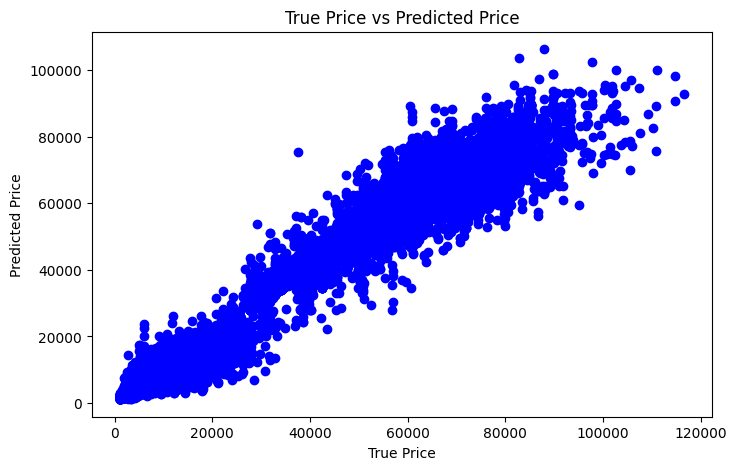

In [66]:
plt.figure(figsize = (8, 5))
plt.scatter(y_test, y_pred, color = 'blue')
plt.xlabel('True Price')
plt.ylabel('Predicted Price')
plt.title('True Price vs Predicted Price')
plt.show()

### Task 4. Hyper-parameter tuning through cross-validation for random forests

You need to perform hyper-parameter tuning through cross-validation for random forests.

<span style="color:red">**[TBC]**</span> Please complete the following tasks:

- Hyper-parameter tuning through cross-validation
- Evaluate the performance of the final model on test dataset
- Get feature importances from the final model

Warning: The difficulty with this task lies in the size of the data set. If your computer doesn't have enough memory to complete the task, you need to find workarounds.

In [72]:
# [TBC] complete your code here with proper comments
# Hyper-parameter tuning through cross-validation
# hint: sklearn.model_selection.GridSearchCV()

param_dict = {
    'criterion': ['gini', 'entropy', 'friedman_mse'], #'absolute_error', 'squared_error', 'poisson'
    'max_depth': [10, 20, 30, 40],
    'bootstrap': [True, False],
    'n_estimators': [100, 200, 300]
}

# Initialize the Random Forest Regressor
rfr = RandomForestRegressor()

# Initialize GridSearchCV
rf_random = GridSearchCV(
    estimator=rfr, 
    param_grid=param_dict, 
    cv=3, 
    verbose=2, 
    n_jobs=-1)

# Fit the model
rf_random.fit(X_train, y_train)


Fitting 3 folds for each of 72 candidates, totalling 216 fits
[CV] END bootstrap=True, criterion=gini, max_depth=10, n_estimators=200; total time=   0.0s
[CV] END bootstrap=True, criterion=gini, max_depth=10, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, criterion=gini, max_depth=10, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, criterion=gini, max_depth=10, n_estimators=200; total time=   0.0s
[CV] END bootstrap=True, criterion=gini, max_depth=10, n_estimators=200; total time=   0.0s
[CV] END bootstrap=True, criterion=gini, max_depth=20, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, criterion=gini, max_depth=20, n_estimators=200; total time=   0.0s
[CV] END bootstrap=True, criterion=gini, max_depth=20, n_estimators=200; total time=   0.0s
[CV] END bootstrap=True, criterion=gini, max_depth=20, n_estimators=200; total time=   0.0s
[CV] END bootstrap=True, criterion=gini, max_depth=20, n_estimators=300; total time=   0.0s
[CV] END bootstrap

GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'criterion': ['gini', 'entropy', 'friedman_mse'],
                         'max_depth': [10, 20, 30, 40],
                         'n_estimators': [100, 200, 300]},
             verbose=2)

In [73]:
print('Best hyper-parameters:', rf_random.best_params_)
print('Best score:', rf_random.best_score_)

Best hyper-parameters: {'bootstrap': True, 'criterion': 'friedman_mse', 'max_depth': 20, 'n_estimators': 300}
Best score: 0.9881036355354387


In [80]:
# [TBC] complete your code here with proper comments
# evaluate the performance of the final model on test dataset
# hint: you may use RMSE and r2 score
# hint: you may also create a plot to visualize the predictions

y_pred = rf_random.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print("Mean Squared Error:", round(mean_squared_error(y_test, y_pred),3))
print(f"Root Mean Squared Error (RMSE): {rmse:.3f}")
print(f"Mean Absolute Error (MAE): {mae:.3f}")
print("R2 Score:", round(r2_score(y_test, y_pred),3))



Mean Squared Error: 5479127.484
Root Mean Squared Error (RMSE): 2340.754
Mean Absolute Error (MAE): 965.628
R2 Score: 0.989


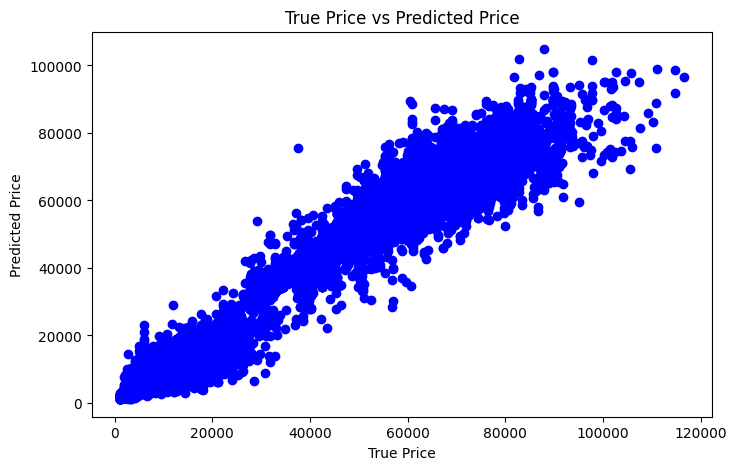

In [75]:
plt.figure(figsize = (8, 5))
plt.scatter(y_test, y_pred, color = 'blue')
plt.xlabel('True Price')
plt.ylabel('Predicted Price')
plt.title('True Price vs Predicted Price')
plt.show()

In [76]:
# [TBC] complete your code here with proper comments
# Get feature importances from the final model
# hint: you may first obtain the best estimator from GridSearchCV
# hint: then get feature importances from the best estimator

best_rfr = rf_random.best_estimator_
feature_importances = best_rfr.feature_importances_
# Print feature importances with feature names
feature_names = feature_df.columns
feature_importance_dict = dict(zip(feature_names, feature_importances))

print("Feature Importances:")
for feature, importance in feature_importance_dict.items():
    print(f"{feature}: {importance}")


Feature Importances:
airline: 0.0010570971593574833
flight: 0.028884109601549197
source_city: 0.006875240244663592
departure_time: 0.0024828847736817457
stops: 0.0020133482702609047
arrival_time: 0.0029215982468338906
destination_city: 0.009909984736768617
class: 0.8811228377696989
duration: 0.04788379875806162
days_left: 0.016849100439124045
